### Classes and modules

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

#Import packages we need
import numpy as np
from netCDF4 import Dataset
import xarray as xr

#For plotting
import matplotlib.pyplot as plt

plt.rcParams["lines.color"] = "w"
plt.rcParams["text.color"] = "w"
plt.rcParams["axes.labelcolor"] = "w"
plt.rcParams["xtick.color"] = "w"
plt.rcParams["ytick.color"] = "w"

from importlib import reload

In [2]:
casename = 'skagerrak'

from gpuocean.utils import NetCDFInitialization
reload(NetCDFInitialization)
case_info = NetCDFInitialization.getCaseLocation(casename)
case_info.pop("name")

'skagerak'

In [3]:
locals().update(case_info)

Calculating Mixed Layer Depth Step by Step

In [4]:
#s_source_url = "C:\\Users\\florianb\\Downloads\\ocean_his.an.20190716.nc"
s_source_url = "https://thredds.met.no/thredds/dodsC/fou-hi/new_norkyst800m/avg/ocean_avg.an.20190716.nc"

In [5]:
s_nc = Dataset(s_source_url)

In [6]:
t = 0

In [7]:
s_lvls = s_nc["Cs_r"][:].data
w_lvls = s_nc["Cs_w"][:].data

In [8]:
s_temps = s_nc["temp"][t,:,y0-1:y1+1,x0-1:x1+1]
s_sals  = s_nc["salt"][t,:,y0-1:y1+1,x0-1:x1+1]

In [9]:
s_hs   = s_nc["h"][y0-1:y1+1,x0-1:x1+1]
s_lats = s_nc["lat_rho"][y0-1:y1+1,x0-1:x1+1]

ny, nx = s_hs.shape

In [10]:
import seawater as sw

In [11]:
s_depths = np.ma.array(np.multiply.outer(s_lvls,s_hs), mask=s_temps.mask.copy())
w_depths = np.ma.array(np.multiply.outer(w_lvls,s_hs), mask=np.array((len(w_lvls)*[s_temps[0].mask.copy()])))

In [12]:
s_pressures = sw.eos80.pres(-s_depths,s_lats)

In [13]:
s_pot_densities = sw.eos80.pden(s_sals,s_temps,s_pressures)

/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/numpy/ma/core.py:6849: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


In [14]:
thres = 1025

In [15]:
# if all s-levels are heavier than the threshold, then set the upper layer (last index, while argmax fills with 0 in such cases)
mld_base_idx = np.ma.maximum(np.argmax(s_pot_densities < thres, axis=0), (len(s_lvls)-1)*(s_pot_densities[-1] > thres))
# ensure that it is not the base index is not the last level 
mld_base_idx = np.ma.maximum(mld_base_idx, 1)

mld_prog_idx = mld_base_idx-1

In [16]:
mld_depth_base = -np.take_along_axis(s_depths, mld_base_idx.reshape(1,ny,nx), axis=0)[0]
mld_dens_base = np.take_along_axis(s_pot_densities, mld_base_idx.reshape(1,ny,nx), axis=0)[0]

mld_depth_prog = -np.take_along_axis(s_depths, mld_prog_idx.reshape(1,ny,nx), axis=0)[0]
mld_dens_prog = np.take_along_axis(s_pot_densities, mld_prog_idx.reshape(1,ny,nx), axis=0)[0]

In [17]:
mld = (thres - mld_dens_base)*(mld_depth_prog - mld_depth_base)/(mld_dens_prog - mld_dens_base) + mld_depth_base

In [18]:
mld[s_pot_densities[-1] > thres] = 0

In [19]:
mld = np.ma.minimum(mld, s_hs)
mld = np.ma.minimum(mld, 40)
mld = np.ma.maximum(mld, 5)

In [20]:
## Smoothing MLD profile to avoid shocks - seems not necessary though

# from scipy.ndimage.filters import convolve, gaussian_filter
# mld = np.ma.array(convolve(np.ma.minimum(mld,-min_mld), [[1/9,1/9,1/9],[1/9,1/9,1/9],[1/9,1/9,1/9]]), mask=s_temps[0].mask.copy())
# mld = np.ma.array(gaussian_filter(mld, [0.1,0.1]), mask=s_temps[0].mask.copy())
# mld = np.ma.minimum(mld, s_hs)
# mld = np.ma.minimum(mld, 40)
# mld = np.ma.maximum(mld, 3)

Calculating Mixed Layer Depth from NetCDFIniitalisation (the same result)

In [21]:
from gpuocean.utils import NetCDFInitialization
from importlib import reload
reload(NetCDFInitialization)

mld = NetCDFInitialization.MLD(s_source_url, thres, min_mld=3, x0=case_info["x0"]-1, x1=case_info["x1"]+1, y0=case_info["y0"]-1, y1=case_info["y1"]+1)

Inspecting MLD in cross sections

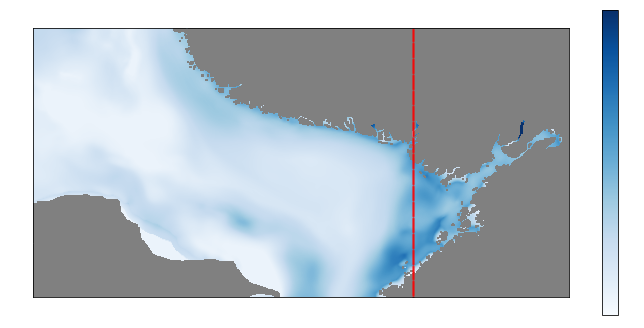

In [69]:
x = 355#225

import copy
cmap = copy.copy(plt.cm.get_cmap("Blues"))
cmap.set_bad("grey")

fig = plt.figure(figsize=(12,8))

plt.imshow(np.ma.array(mld, mask=s_temps[0].mask.copy()), origin="lower", cmap=cmap, vmax=50, vmin=0)
plt.colorbar(shrink=0.7)
plt.scatter(np.repeat(x,ny), np.arange(ny), c="red", s=2.0, alpha=0.5)

In [80]:
s_pot_densities_show = np.ma.array(np.zeros((ny,1000)))
for l in range(ny):
    d_up = 0 
    for i in reversed(range(len(s_lvls))):
        d = round(-(s_hs[l,x]*s_lvls[i]))
        s_pot_densities_show[l,d_up:d] = s_pot_densities[i,l,x]
        d_up = d
s_pot_densities_show.mask = (s_pot_densities_show<0.1)

idxs_show = np.arange(len(s_pot_densities_show.T[0]))#[s_pot_densities_show.T[0].mask == False]

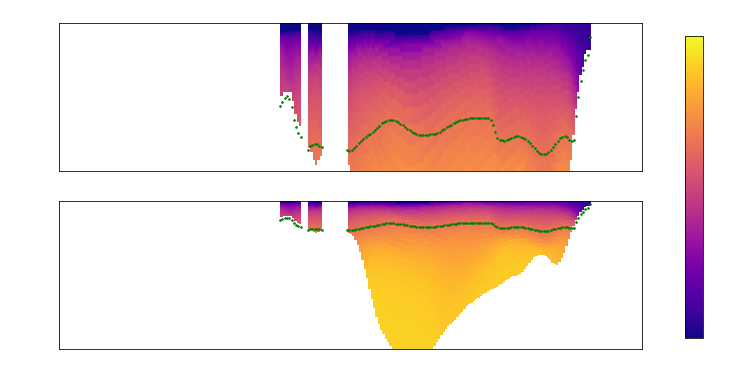

In [73]:
fig, axs = plt.subplots(2,1,figsize=(12,6))

im = axs[0].imshow(np.flip(s_pot_densities_show.T[0:35,idxs_show], axis=1), vmin=1020, vmax=1028, cmap="plasma",  aspect='auto')
axs[0].set_ylabel("Depth \n(zoom in)")
axs[0].set_title("Potential Densities")

axs[0].scatter(np.arange(len(idxs_show)),np.flip(mld[idxs_show,x]), c="green", s=2.5)

im = axs[1].imshow(np.flip(s_pot_densities_show.T[0:150,idxs_show],axis=1), vmin=1020, vmax=1028, cmap="plasma",  aspect='auto')
axs[1].set_ylabel("Depth \n(full)")
plt.xlabel("West <<<   >>> East")
axs[1].scatter(np.arange(len(idxs_show)),np.flip(mld[idxs_show,x]), c="green", s=2.5)


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax, label="kg/m3")


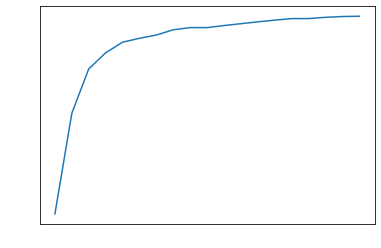

In [81]:
plt.plot(s_pot_densities_show.T[:,idxs_show[-1]])

Mixed Layer integration - step by step

(needed for initalisation of simulations)

In [25]:
mld_upper_idx = np.maximum(np.argmax(-w_depths < mld, axis=0), 1)

In [26]:
depths_diff = w_depths[1:] - w_depths[:-1]

In [27]:
weights = np.ma.array(np.zeros_like(depths_diff), mask=depths_diff.mask.copy())

In [28]:
lvl_idxs = (np.arange(35)[:,np.newaxis,np.newaxis]*np.ones((35,ny,nx)))

In [29]:
weights[lvl_idxs >= mld_upper_idx] = 1

In [30]:
mld_lower_idx = np.ma.maximum(mld_upper_idx - 1,0)

In [31]:
mld_upper_depth = -np.take_along_axis(w_depths, mld_upper_idx.reshape(1,ny,nx), axis=0)[0]
mld_lower_depth = -np.take_along_axis(w_depths, mld_lower_idx.reshape(1,ny,nx), axis=0)[0]

In [32]:
np.put_along_axis(weights, mld_lower_idx.reshape(1,ny,nx), ((mld - mld_upper_depth)/(mld_lower_depth - mld_upper_depth)), axis=0)

In [33]:
integrator = weights * depths_diff

Mixed Layer Integration - by NetCDFInitialisation function (the same result)

In [34]:
integrator = NetCDFInitialization.MLD_integrator(s_source_url, mld, x0=x0-1, x1=x1+1, y0=y0-1, y1=y1+1)

Inspecting use of integrator

In [35]:
ml_pot_densities = np.sum(integrator * s_pot_densities, axis=0)/np.sum(integrator, axis=0)

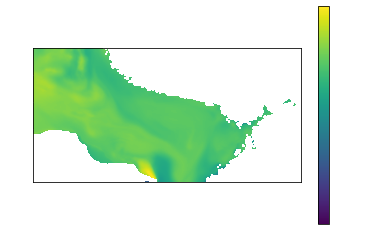

In [36]:
plt.imshow(ml_pot_densities, origin="lower")
plt.colorbar()